This lab on Support Vector Machines in R is an abbreviated version of p. 359-366 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. It was re-implemented in Fall 2016 in `tidyverse` format by Amelia McNamara and R. Jordan Crouser at Smith College.

# 9.6 Lab: Support Vector Machines

In this lab, we'll use the `e1071` library in `R` to demonstrate the support vector classifier
and the SVM. Another option is the `LiblineaR` library, which is particularly useful for
very large linear problems.

# 9.6.1 Support Vector Classifier
The `e1071` library contains implementations for a number of statistical
learning methods. In particular, the `svm()` function can be used to fit a
support vector classifier when the argument `kernel="linear"` is used. This
function uses a slightly different formulation of the equations we saw in lecture to build the
support vector classifier. A `cost` argument allows us to specify the cost of
a violation to the margin. When the `cost` argument is **small**, then the margins
will be wide and many support vectors will be on the margin or will
violate the margin. When the `cost` argument is large, then the margins will
be narrow and there will be few support vectors on the margin or violating
the margin.

We can use the `svm()` function to fit the support vector classifier for a
given value of the `cost` parameter. Here we demonstrate the use of this
function on a two-dimensional example so that we can plot the resulting
decision boundary. Let's start by generating a set of observations, which belong
to two classes:

In [1]:
list.of.packages <- c("dplyr","e1071","ggplot2","ROCR")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)

In [2]:
set.seed(1)
x = matrix(rnorm(20*2), ncol=2)
class = c(rep(-1,10), rep(1,10))
x[class == 1,] = x[class == 1,] + 1

Let's plot the data to see whether the classes are linearly separable:

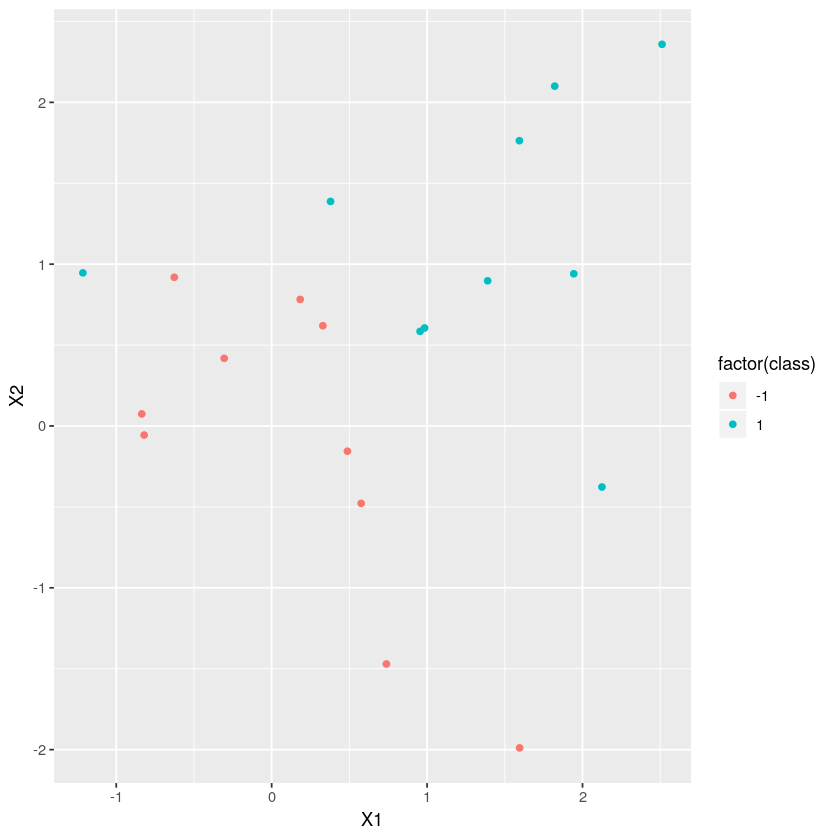

In [3]:
library(ggplot2)
ggplot(data.frame(x), aes(X1, X2, colour = factor(class))) +
  geom_point()

Nope; not linear. Next, we fit the support vector classifier. Note that in order
for the `svm()` function to perform **classification** (as opposed to SVM-based
regression), we must encode the response as a **factor**:

In [4]:
training_data = data.frame(x = x, class = as.factor(class))

library(e1071)
svmfit = svm(class~., 
             data = training_data, 
             kernel = "linear", 
             cost = 10, 
             scale = FALSE)

The argument `scale = FALSE` tells the `svm()` function not to scale each feature
to have mean zero or standard deviation one; depending on the application,
we might prefer to use `scale = TRUE`. We can now plot the support vector classifier by calling the `plot()` function on the output of the call to `svm()`, as well as the data used in the call to `svm()`:

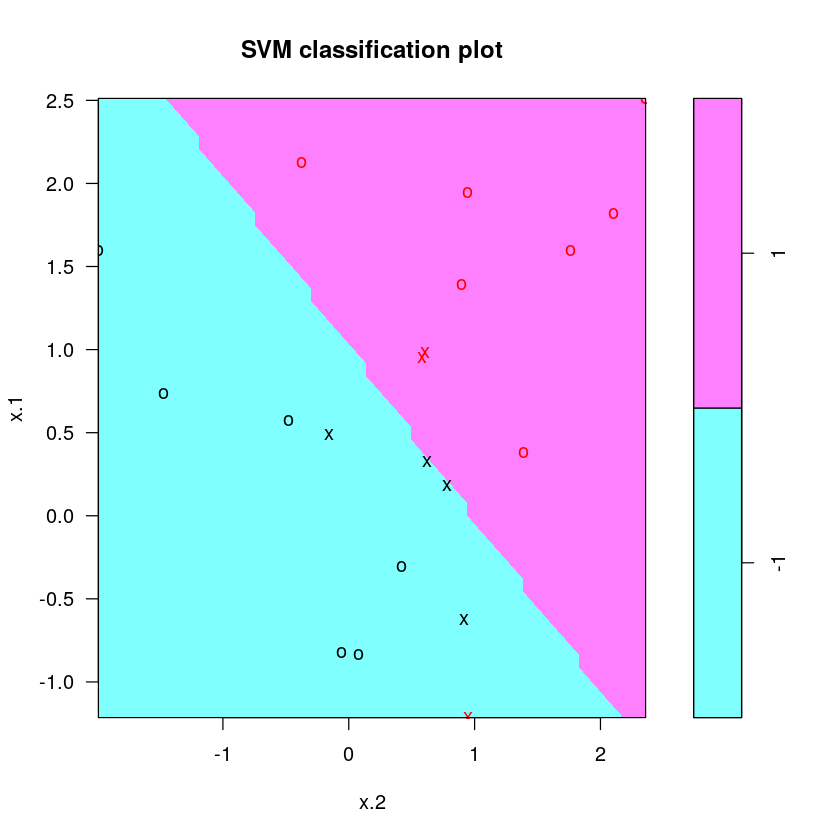

In [5]:
plot(svmfit, training_data)

The region of feature space that will be assigned to the −1 class is shown in
light blue, and the region that will be assigned to the +1 class is shown in
purple. The decision boundary between the two classes is linear (because we
used the argument `kernel = "linear"`), though due to the way in which the
plotting function is implemented in this library the decision boundary looks
somewhat jagged in the plot. We see that in this case only one observation
is misclassified. (Note also that the second feature is plotted on the x-axis
and the first feature is plotted on the y-axis, in contrast to the behavior of
the usual `plot()` function in `R`.) 

The support vectors are plotted as crosses
and the remaining observations are plotted as circles; we see here that there
are seven support vectors. We can determine their identities as follows:

In [6]:
svmfit$index

[1]  1  2  5  7 14 16 17

We can obtain some basic information about the support vector classifier
fit using the `summary()` command:

In [7]:
summary(svmfit)


Call:
svm(formula = class ~ ., data = training_data, kernel = "linear", 
    cost = 10, scale = FALSE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  10 
      gamma:  0.5 

Number of Support Vectors:  7

 ( 4 3 )


Number of Classes:  2 

Levels: 
 -1 1




This tells us, for instance, that a linear kernel was used with `cost = 10`, and
that there were seven support vectors, four in one class and three in the
other. What if we instead used a smaller value of the `cost` parameter?

[1]  1  2  3  4  5  7  9 10 12 13 14 15 16 17 18 20

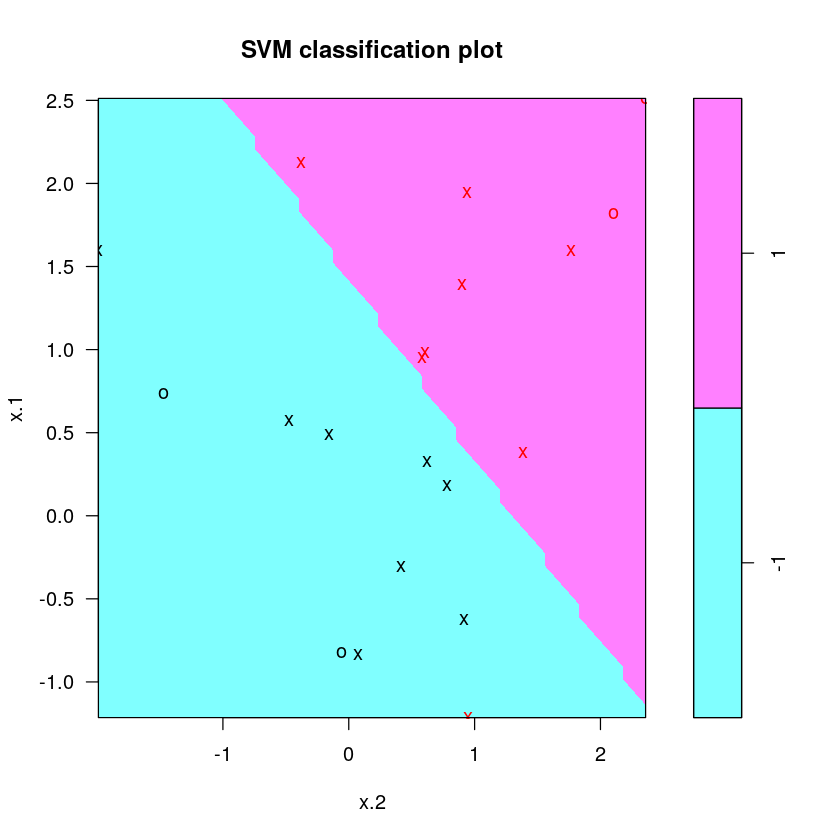

In [8]:
svmfit = svm(class~., 
             data = training_data, 
             kernel = "linear", 
             cost = 0.1, 
             scale = FALSE)

plot(svmfit, training_data)
svmfit$index

Now that a smaller value of the `cost` parameter is being used, we obtain a
larger number of support vectors, because the margin is now **wider**. Unfortunately,
the `svm()` function does not explicitly output the coefficients of
the linear decision boundary obtained when the support vector classifier is
fit, nor does it output the width of the margin.

The `e1071` library includes a built-in function, `tune()`, to perform cross-validation. By default, `tune()` performs **ten-fold cross-validation** on a set
of models of interest. In order to use this function, we pass in relevant
information about the set of models that are under consideration. The
following command indicates that we want to compare SVMs with a linear
kernel, using a range of values of the cost parameter:

In [9]:
set.seed(1)
tune_out = tune(svm, 
                class~., 
                data = training_data, 
                kernel = "linear", 
                ranges = list(cost = c(0.001, 0.01, 0.1, 1,5,10,100)))

We can easily access the cross-validation errors for each of these models
using the `summary()` command:

In [10]:
summary(tune_out)


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 cost
  0.1

- best performance: 0.1 

- Detailed performance results:
   cost error dispersion
1 1e-03  0.70  0.4216370
2 1e-02  0.70  0.4216370
3 1e-01  0.10  0.2108185
4 1e+00  0.15  0.2415229
5 5e+00  0.15  0.2415229
6 1e+01  0.15  0.2415229
7 1e+02  0.15  0.2415229


The `tune()` function stores the best model obtained, which can be accessed as
follows:

In [11]:
bestmod = tune_out$best.model
summary(bestmod)


Call:
best.tune(method = svm, train.x = class ~ ., data = training_data, 
    ranges = list(cost = c(0.001, 0.01, 0.1, 1, 5, 10, 100)), kernel = "linear")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  0.1 
      gamma:  0.5 

Number of Support Vectors:  16

 ( 8 8 )


Number of Classes:  2 

Levels: 
 -1 1




As usual, the `predict()` function can be used to predict the class label on a set of
test observations, at any given value of the cost parameter. Let's
generate a test data set:

In [12]:
xtest = matrix(rnorm(20*2), ncol = 2)
ytest = sample(c(-1,1), 20, rep = TRUE)
xtest[ytest == 1,] = xtest[ytest == 1,] + 1
test_data = data.frame(x = xtest, class = as.factor(ytest))

Now we predict the class labels of these test observations. Here we use the
best model obtained through cross-validation in order to make predictions:

In [13]:
class_pred = predict(bestmod, test_data)
table(predicted = class_pred, true = test_data$class)

         true
predicted -1  1
       -1 11  1
       1   0  8

Thus, with this value of `cost`, 19 of the test observations are correctly
classified. What if we had instead used `cost = 0.01`?

In [14]:
svmfit = svm(class~., data = training_data, kernel = "linear", cost = .01, scale = FALSE)
class_pred = predict(svmfit, test_data)
table(predicted = class_pred, true = test_data$class)

         true
predicted -1  1
       -1 11  2
       1   0  7

In this case one additional observation is misclassified.

Now consider a situation in which the two classes are linearly separable.
Then we can find a separating hyperplane using the `svm()` function. First we'll give our simulated data a little nudge so that they are linearly separable:

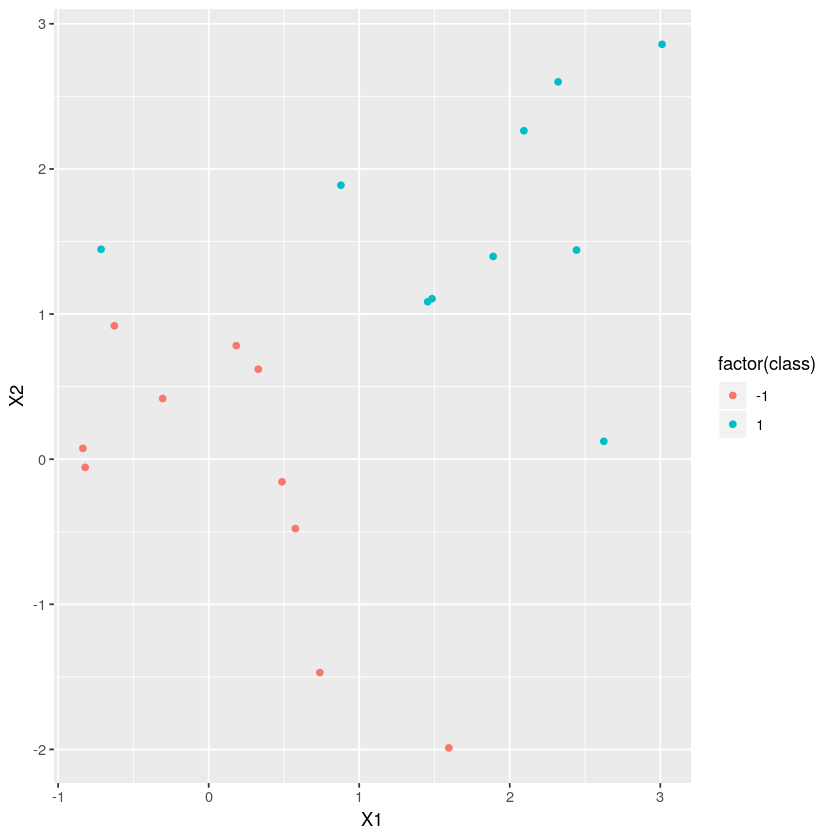

In [15]:
x[class == 1,] = x[class == 1,] + 0.5
ggplot(data.frame(x), aes(X1, X2, colour = factor(class))) +
  geom_point()

Now the observations are **just barely linearly** separable. We fit the support
vector classifier and plot the resulting hyperplane, using a very large value
of `cost` so that no observations are misclassified.


Call:
svm(formula = class ~ ., data = training_data2, kernel = "linear", 
    cost = 1e+05)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1e+05 
      gamma:  0.5 

Number of Support Vectors:  3

 ( 1 2 )


Number of Classes:  2 

Levels: 
 -1 1




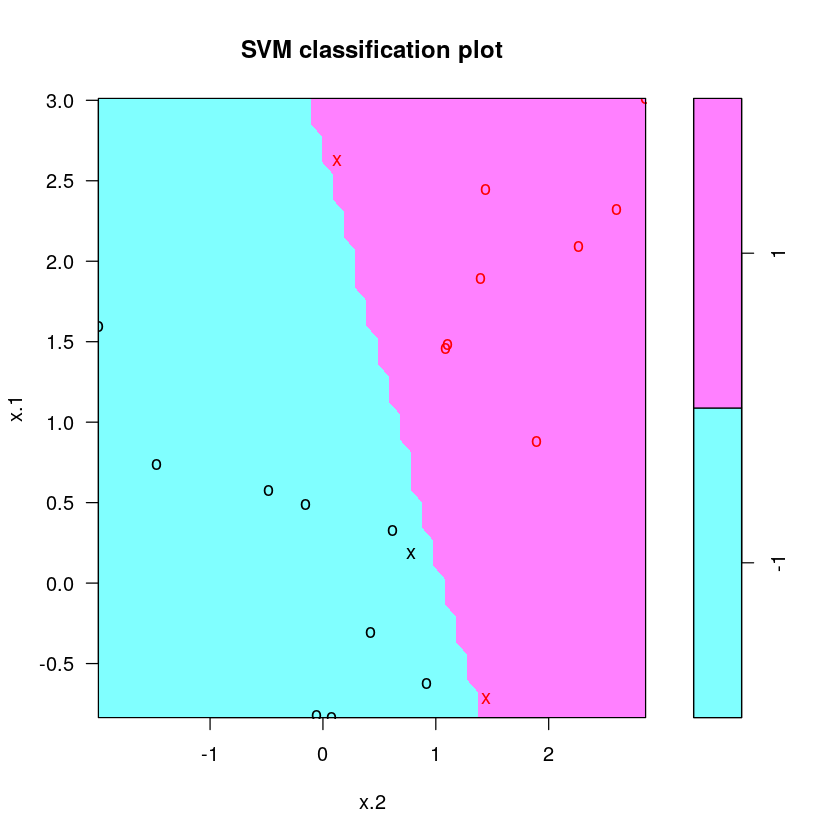

In [16]:
training_data2 = data.frame(x = x, class = as.factor(class))
svmfit = svm(class~., data = training_data2, kernel = "linear", cost = 1e5)
summary(svmfit)
plot(svmfit, training_data2)

No training errors were made and only three support vectors were used.
However, we can see from the figure that the margin is very narrow (because
the observations that are **not** support vectors, indicated as circles, are very close to the decision boundary). It seems likely that this model will perform
poorly on test data. Let's try a smaller value of `cost`:


Call:
svm(formula = class ~ ., data = training_data2, kernel = "linear", 
    cost = 1)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1 
      gamma:  0.5 

Number of Support Vectors:  7

 ( 4 3 )


Number of Classes:  2 

Levels: 
 -1 1




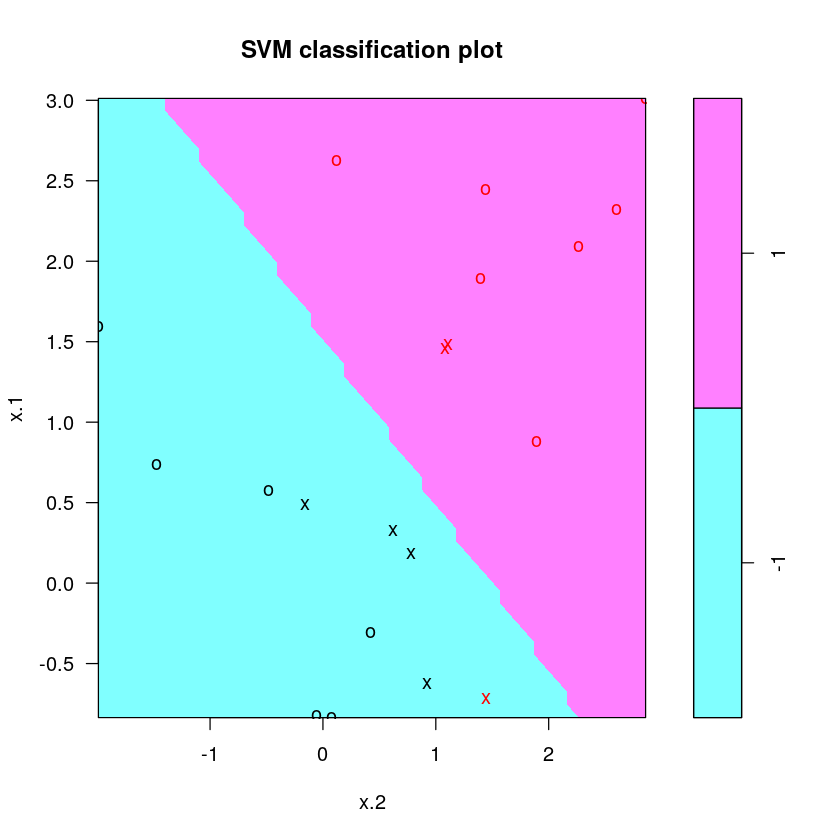

In [17]:
svmfit = svm(class~., data = training_data2, kernel = "linear", cost = 1)
summary(svmfit)
plot(svmfit, training_data2)

Using `cost = 1`, we misclassify a training observation, but we also obtain
a much wider margin and make use of seven support vectors. It seems
likely that this model will perform better on test data than the model with
`cost = 1e5`.

# 9.6.2 Support Vector Machine

In order to fit an SVM using a **non-linear kernel**, we once again use the `svm()`
function. However, now we use a different value of the parameter kernel.
To fit an SVM with a polynomial kernel we use `kernel="polynomial"`, and
to fit an SVM with a radial kernel we use `kernel="radial"`. In the former
case we also use the `degree` argument to specify a degree for the polynomial
kernel, and in the latter case we use `gamma` to specify a
value of $\gamma$ for the radial basis kernel.

Let's generate some data with a non-linear class boundary:

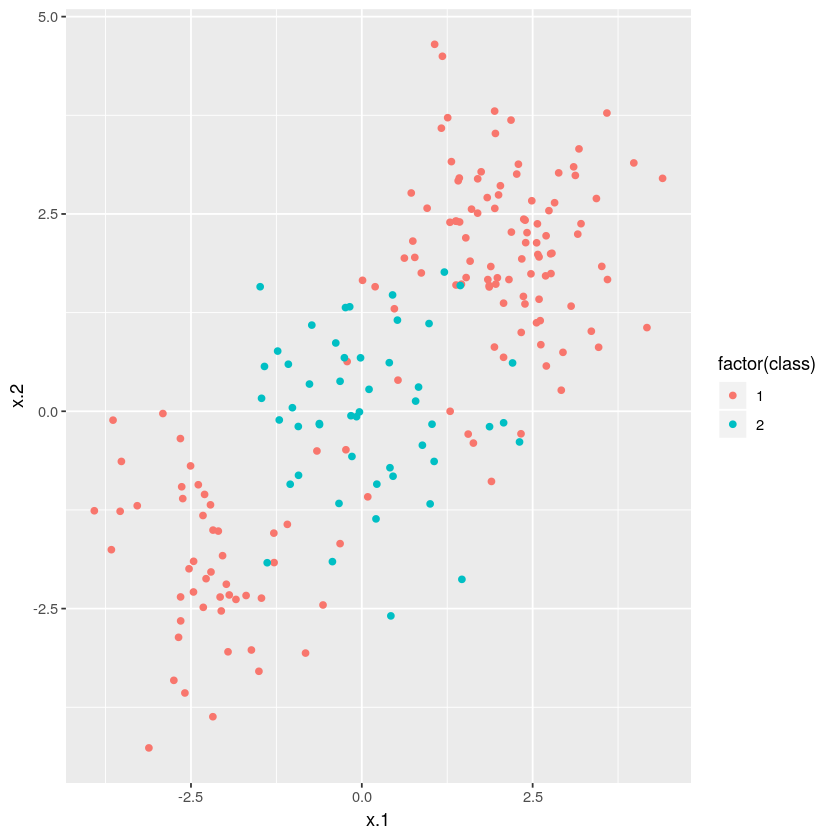

In [18]:
set.seed(1)
x = matrix(rnorm(200*2), ncol = 2)
x[1:100,] = x[1:100,]+2
x[101:150,] = x[101:150,]-2
class = c(rep(1,150),rep(2,50))
nonlinear_data = data.frame(x = x, class = as.factor(class))

ggplot(nonlinear_data, aes(x.1, x.2, colour = factor(class))) +
  geom_point()

See how one class is kind of stuck in the middle of another class? This suggests that we might want to use a **radial kernel** in our SVM. Now let's randomly split this data into training and testing groups, and then fit
the training data using the `svm()` function with a radial kernel and $\gamma = 1$:


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



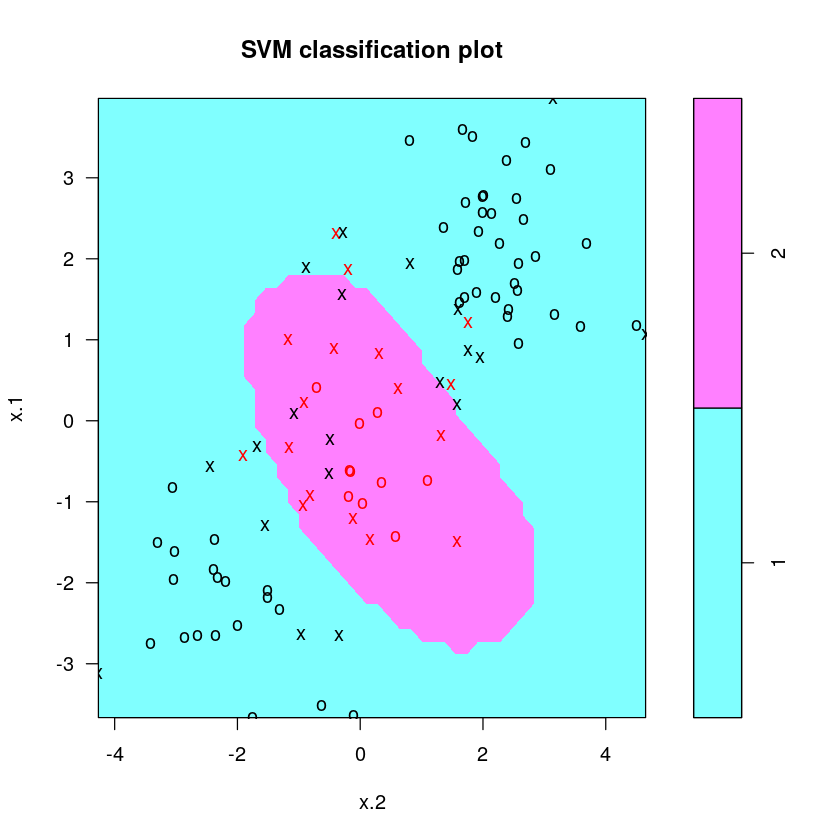

In [19]:
library(dplyr)

nonlinear_train = nonlinear_data %>%
  sample_frac(0.5)

nonlinear_test = nonlinear_data %>%
  setdiff(nonlinear_train)

svmfit = svm(class~., data = nonlinear_train, kernel = "radial",  gamma = 1, cost = 1)
plot(svmfit, nonlinear_train)

Not too shabby! The plot shows that the resulting SVM has a decidedly non-linear
boundary. We can see from the figure that there are a fair number of training errors
in this SVM fit. If we increase the value of cost, we can reduce the number
of training errors:

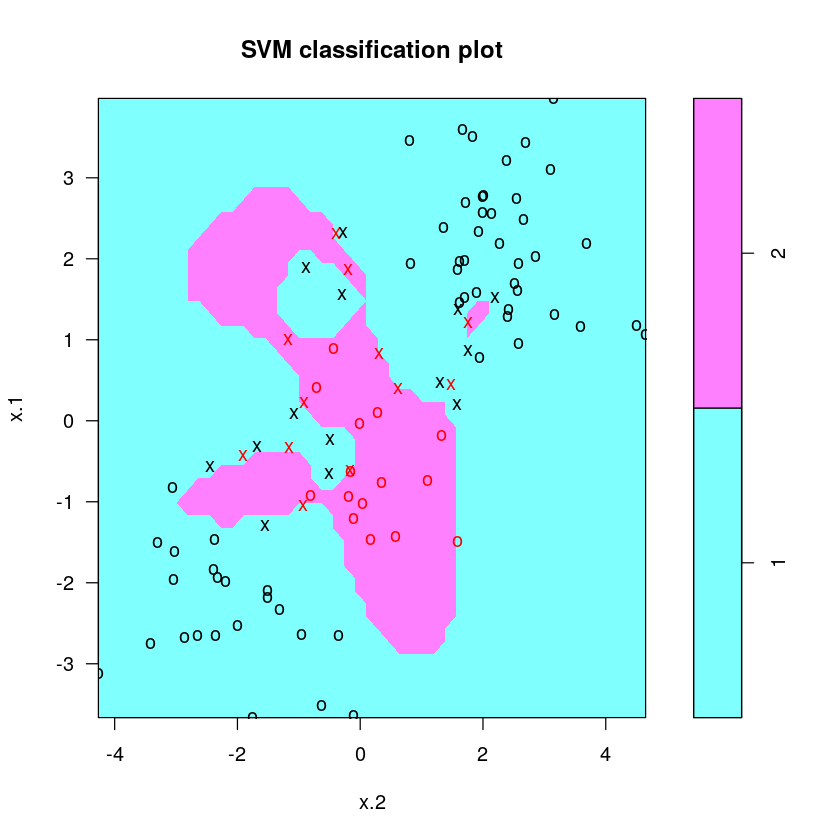

In [20]:
svmfit = svm(class~., data = nonlinear_train, kernel = "radial", gamma = 1, cost = 1e5)
plot(svmfit, nonlinear_train)

However, this comes at the price of a more irregular decision boundary that seems to be at risk of overfitting the data. We can perform cross-validation using `tune()` to select the best choice of
$\gamma$ and cost for an SVM with a radial kernel:

In [21]:
set.seed(1)
tune_out = tune(svm, class~., data = nonlinear_train, kernel = "radial",
                ranges = list(cost = c(0.1,1,10,100,1000), gamma = c(0.5,1,2,3,4)))
bestmod = tune_out$best.model
summary(bestmod)


Call:
best.tune(method = svm, train.x = class ~ ., data = nonlinear_train, 
    ranges = list(cost = c(0.1, 1, 10, 100, 1000), gamma = c(0.5, 
        1, 2, 3, 4)), kernel = "radial")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  2 

Number of Support Vectors:  43

 ( 17 26 )


Number of Classes:  2 

Levels: 
 1 2




Therefore, the best choice of parameters involves `cost = 1` and `gamma = 2`. We
can plot the resulting fit using the `plot()` function, and view the test set predictions for this model by applying the `predict()`
function to the test data.

In [ ]:
plot(bestmod, nonlinear_train)
table(true = nonlinear_test$class, pred = predict(tune_out$best.model, newdata = nonlinear_test))

90% of test observations are correctly classified by this SVM. Not bad!

# 9.6.3 ROC Curves

The `ROCR` package can be used to produce ROC curves such as those we saw in lecture. We first write a short function to plot an ROC curve
given a vector containing a numerical score for each observation, `pred`, and
a vector containing the class label for each observation, `truth`:

In [22]:
library(ROCR)
rocplot = function(pred, truth, ...){
   predob = prediction(pred, truth)
   perf = performance(predob, "tpr", "fpr")
   plot(perf,...)}

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



SVMs and support vector classifiers output class labels for each observation.
However, it is also possible to obtain fitted values for each observation,
which are the numerical scores used to obtain the class labels. For instance,
in the case of a support vector classifier, the fitted value for an observation
$X = (X_1,X_2, . . .,X_p)^T$ takes the form $\hat\beta_0 + \hat\beta_1X_1 + \hat\beta_2X_2 + . . . + \hat\beta_pX_p$.

For an SVM with a non-linear kernel, the equation that yields the fitted
value is given in (9.23) on p. 352 of the ISLR book. In essence, the sign of the fitted value determines
on which side of the decision boundary the observation lies. Therefore, the
relationship between the fitted value and the class prediction for a given
observation is simple: if the fitted value exceeds zero then the observation
is assigned to one class, and if it is less than zero than it is assigned to the
other.

In order to obtain the fitted values for a given SVM model fit, we
use `decision.values=TRUE` when fitting `svm()`. Then the `predict()` function
will output the fitted values. Let's fit models using the $\gamma$ selected by cross-validation, and a higher value, which will produce a more flexible fit:

In [23]:
svmfit_opt = svm(class~., data = nonlinear_train, kernel = "radial", 
                 gamma = 2, cost = 1, decision.values = TRUE)

svmfit_flex = svm(class~., data = nonlinear_train, kernel = "radial", 
                  gamma = 50, cost = 1, decision.values = TRUE)

Now we can produce the ROC plot to see how the models perform on both the training and the test data:

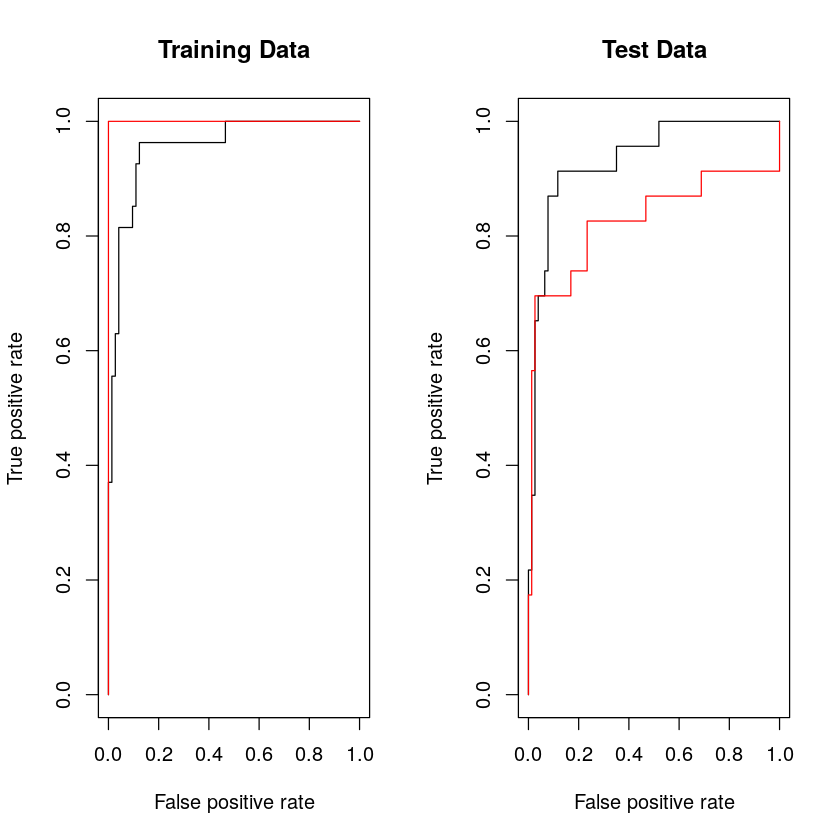

In [24]:
par(mfrow = c(1,2))

# Plot optimal parameter model's performance on training data
fitted_opt_train = attributes(predict(svmfit_opt, nonlinear_train, 
                                      decision.values = TRUE))$decision.values
rocplot(fitted_opt_train, nonlinear_train$class, main = "Training Data")

# Add more flexible model's performance to the plot
fitted_flex_train = attributes(predict(svmfit_flex, nonlinear_train,
                                       decision.values = TRUE))$decision.values
rocplot(fitted_flex_train, nonlinear_train$class, add = TRUE, col = "red")

# Plot optimal parameter model's performance on test data
fitted_opt_test = attributes(predict(svmfit_opt, nonlinear_test, 
                                     decision.values = TRUE))$decision.values
rocplot(fitted_opt_test, nonlinear_test$class, main = "Test Data")

# Add more flexible model's performance to the plot
fitted_flex_test = attributes(predict(svmfit_flex, nonlinear_test, 
                                      decision.values = TRUE))$decision.values
rocplot(fitted_flex_test, nonlinear_test$class, add = TRUE, col = "red")

# 9.6.4 SVM with Multiple Classes

If the response is a factor containing more than two levels, then the ${\tt svm()}$
function will perform multi-class classification using the one-versus-one approach.
We explore that setting here by generating a third class of observations:

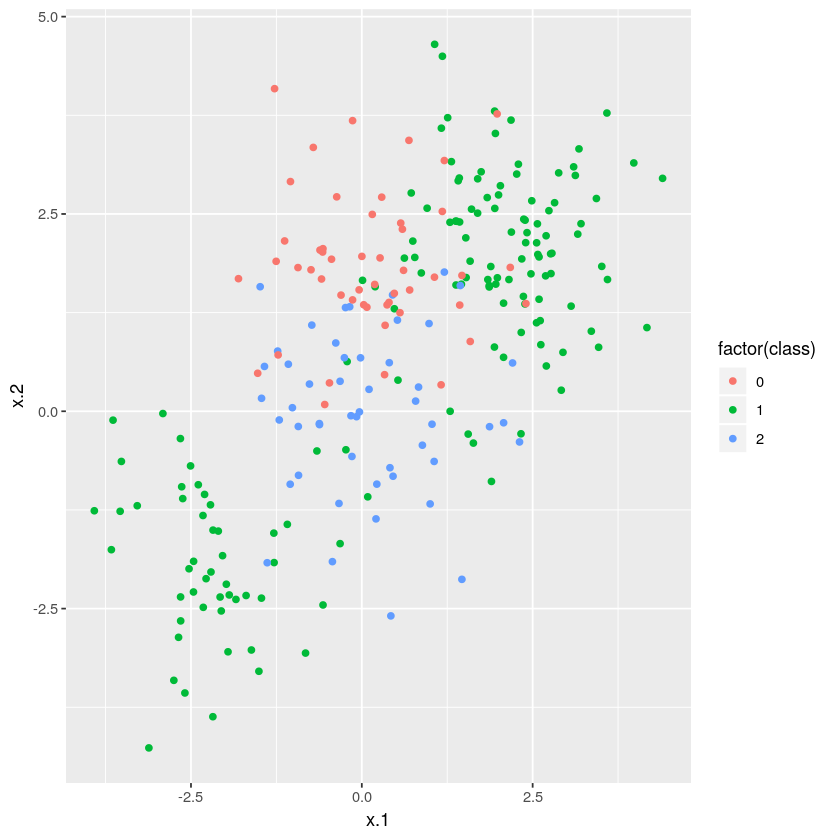

In [25]:
x = rbind(x, matrix(rnorm(50*2), ncol = 2))
class = c(class, rep(0,50))
x[class == 0,2] = x[class == 0,2]+2
data_3_classes = data.frame(x = x, class = as.factor(class))

ggplot(data_3_classes, aes(x.1, x.2, colour = factor(class))) +
  geom_point()

Fitting an SVM to multiclass data uses identical syntax to fitting a simple two-class model:

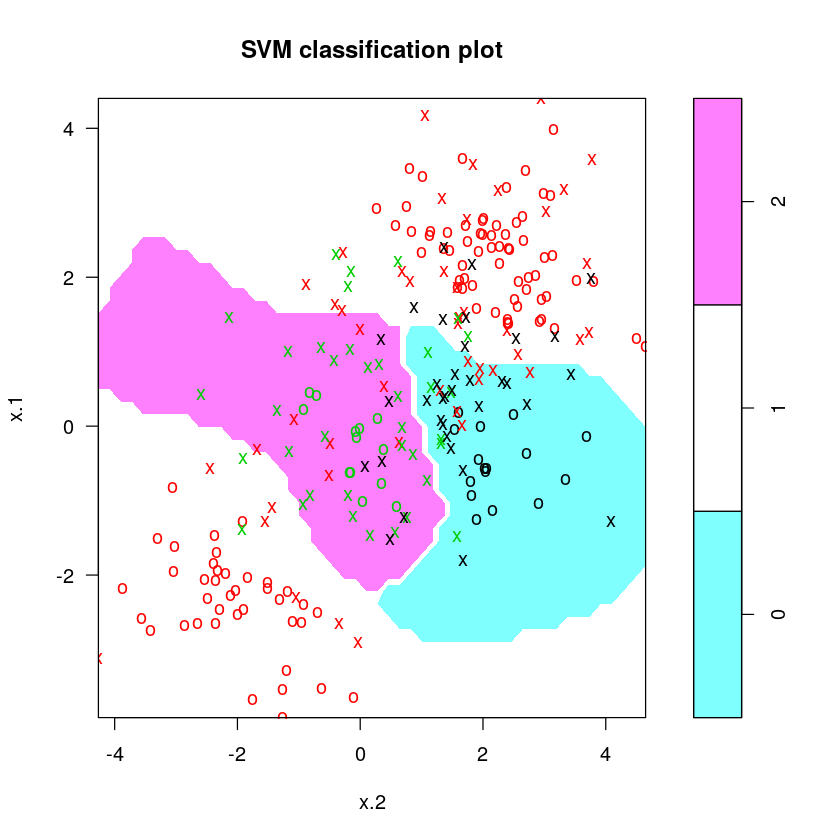

In [26]:
svmfit = svm(class~., data = data_3_classes, kernel = "radial", cost = 10, gamma = 1)
plot(svmfit, data_3_classes)

The `e1071` library can also be used to perform support vector regression,
if the response vector that is passed in to `svm()` is numerical rather than a
factor.

# Application to Handwritten Letter Data

We now examine [`Optical Recognition of Handwritten Digits Data Set`](http://archive.ics.uci.edu/ml/datasets/optical+recognition+of+handwritten+digits), which contains 5,620 samples of handwritten digits 0..9. You can use these links to download the [training data](http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tra) and [test data](http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tes), and then we'll load them into R:

In [27]:
digits_train = read.csv("https://raw.githubusercontent.com/kchmck/perceptrons/master/optdigits.tra", header = FALSE)
digits_train = data.frame(x = digits_train[,-1], y = as.factor(digits_train[,65]))

digits_test = read.csv("https://raw.githubusercontent.com/kchmck/perceptrons/master/optdigits.tes", header = FALSE)
digits_test = data.frame(x = digits_test[,-1], y = as.factor(digits_test[,65]))

Warning message in file(file, "rt"):
“cannot open file 'optdigits.tra': File o directory non esistente”

ERROR: Error in file(file, "rt"): non posso aprire questa connessione


Let's take a look at the dimensions of this dataset:

In [ ]:
dim(digits_train)
dim(digits_test)

This data set consists of preprocessed images of handwriting samples gathered from 43 different people. Each image was converted into an 8x8 matrix (64 pixels), which was then flattened into a vector of 64 numeric values. The final column contains the class label for each digit.

The training and test sets consist of 3,823 and 1,797 observations respectively. Let's see what one of these digits looks like:

In [ ]:
m = matrix(unlist(digits_train[1,-1]),8,8)
image(m, axes = FALSE, col = grey(seq(0, 1, length = 256)))

That's a pretty messy digit. Let's peek at the true class:

In [ ]:
digits_train[1,65]

Phew, looks like our SVM has its work cut out for it! Let's start with a linear kernel to see how we do:

In [ ]:
digits_svm = svm(y~., data = digits_train, kernel = "linear", cost = 10, scale = FALSE)
table(digits_svm$fitted, digits_train$y)

We see that there are **no training errors**. In fact, this is not surprising,
because the large number of variables relative to the number of observations
implies that it is easy to find hyperplanes that fully separate the classes. We
are most interested not in the support vector classifier’s performance on the
training observations, but rather its performance on the test observations:

In [ ]:
pred = predict(digits_svm, newdata = digits_test)
table(pred, digits_test$y)

We see that using `cost = 10` yields just 40 test set errors on this data. Now try using the `tune()` function to select an optimal value for `cost`, and refit the model using that value. Consider values in the range 0.01 to 100:

In [ ]:
# Your code here

To get credit for this lab, report your optimal values and comment on your final model's performance on Moodle: https://moodle.smith.edu/mod/quiz/view.php?id=266457